## Code

In [1]:
import pandas
import numpy as np
import math

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Note: forces*R != moments since the center of force may change!
# Note: It's ok that many of these results will have negative Cp... haris had 3 out of 250 with positive results!

In [4]:
def convert_to_num(xyz):
    """Converts x->0, y->1, z->2. Throws an Exception otherwise."""
    if 'x'==xyz:
        return 0
    elif 'y'==xyz:
        return 1
    elif 'z'==xyz:
        return 2
    raise Exception('coord must be "x", "y", or "z"')

In [5]:
def test_convert_to_num():
    """Ensures convert_to_num works as expected."""
    assert 0 == convert_to_num('x')
    assert 1 == convert_to_num('y')
    assert 2 == convert_to_num('z')
    try:
        convert_to_num('w')
        assert False, "Should throw error"
    except AssertionError:
        assert False, "Should throw error"
    except:
        pass

test_convert_to_num()

In [6]:
def get_times_values(filename, coord):
    """Reads filename as Pandas DF and gets columns for time and total_{coord}"""
    f = pandas.read_csv(filename, sep='\t', header=3)
    f = f.rename(columns=lambda x: x.strip())
    times = f["# Time"]
    values = [float(i.strip(",").strip("(),").split(" ")[convert_to_num(coord)]) for i in f["(total_x total_y total_z)"]]
    return times, values 

In [7]:
def filter_to_settled(times, values):
    """Transient part assumed to be 2/3 of simulation, minus 2/3 of a second. Filter to last 1/3 of times."""
    critical_time = (list(times)[-1] - 1)/1.5
    output_times = np.array([t for t in times if t > critical_time])
    return output_times, values[len(values) - len(output_times):] 

In [8]:
def test_filter_to_settled():
    """Ensures filter_to_settled chooses up to (but not more than) 1/3 of total points."""
    for i in [0,1]:
        assert 3 == len(filter_to_settled(list(range(7)), list(range(7)))[i])
        assert 3 == len(filter_to_settled(list(range(8)), list(range(8)))[i])
        assert 4 == len(filter_to_settled(list(range(9)), list(range(9)))[i])
        assert 1 == len(filter_to_settled(list(range(2)), list(range(2)))[i])
    
test_filter_to_settled()

In [9]:
def filter_to_half_rotations(times, values, omega):
    """Filters to a positive integer of half rotations of the given data, to keep data even across 0<=θ<π."""
    half_rotation_time=math.pi/abs(omega)
    print("Time in a half rotation (seconds):", half_rotation_time)
    num_half_rotations =(list(times)[-1] - list(times)[0]) / half_rotation_time
    print("Number of half rotations:", num_half_rotations)
    if num_half_rotations < 1:
        raise Exception("Data must contain at least 1 half-rotation")
    filtered_times = times[times < (list(times)[0] + math.floor(num_half_rotations)*half_rotation_time)]
    filtered_values = list(values)[:len(filtered_times)]
    print("Filtering to " + str(len(filtered_times)) + " points")
    return filtered_times, filtered_values

In [10]:
def test_filter_to_half_rotations():
    """Ensures filter_to_half_rotations filters the correct amount of points."""
    for i in [0,1]:
        assert 18 == len(filter_to_half_rotations(pandas.Series(range(20)), pandas.Series(range(20)), -math.pi/3)[i])
        assert 18 == len(filter_to_half_rotations(pandas.Series(range(20)), pandas.Series(range(20)), math.pi/2)[i])
        assert 10 == len(filter_to_half_rotations(pandas.Series(range(20)), pandas.Series(range(20)), math.pi/10)[i]), "Should round down (1 point from next half-rot must exist)"
        assert 20 == len(filter_to_half_rotations(pandas.Series(range(21)), pandas.Series(range(21)), math.pi/10)[i])
        assert 14 == len(filter_to_half_rotations(pandas.Series(range(20)), pandas.Series(range(20)), math.pi/7)[i])
    try:
        filter_to_half_rotations(pandas.Series(range(20)), pandas.Series(range(20)), math.pi/30)
        assert False, "Should throw error"
    except AssertionError:
        assert False, "Should throw error"
    except:
        pass
        
test_filter_to_half_rotations()

Time in a half rotation (seconds): 3.0
Number of half rotations: 6.333333333333333
Filtering to 18 points
Time in a half rotation (seconds): 2.0
Number of half rotations: 9.5
Filtering to 18 points
Time in a half rotation (seconds): 10.0
Number of half rotations: 1.9
Filtering to 10 points
Time in a half rotation (seconds): 10.0
Number of half rotations: 2.0
Filtering to 20 points
Time in a half rotation (seconds): 7.0
Number of half rotations: 2.7142857142857144
Filtering to 14 points
Time in a half rotation (seconds): 3.0
Number of half rotations: 6.333333333333333
Filtering to 18 points
Time in a half rotation (seconds): 2.0
Number of half rotations: 9.5
Filtering to 18 points
Time in a half rotation (seconds): 10.0
Number of half rotations: 1.9
Filtering to 10 points
Time in a half rotation (seconds): 10.0
Number of half rotations: 2.0
Filtering to 20 points
Time in a half rotation (seconds): 7.0
Number of half rotations: 2.7142857142857144
Filtering to 14 points
Time in a half rot

In [11]:
def analyze(filename, omega, coord, plot=False):
    """Gets settled values in integer half-rotations, and plots them."""
    times, values = get_times_values(filename, coord)
    if values[-1] > 1e5:
        raise Exception("Data may be corrupted; last value is " + str(values[-1]))

    settled_times, settled_values = filter_to_settled(times, values)
    if plot:
        plt.plot(settled_times, settled_values)
        plt.title(filename + " (" + coord + ")")
        plt.xlabel("simulated time (s)")
        plt.ylabel("total in %s" % coord)

    half_rotation_times, half_rotation_values = filter_to_half_rotations(settled_times, settled_values, omega)
    if plot:
        plt.plot(half_rotation_times, half_rotation_values)

    return half_rotation_values

In [12]:
# Note: Theoretical max power = 0.5 rho A v^3
#                             = 0.5 1 (2rh) v^3 (rho normalized; 1 kg/m^3)
#                             = r v^3 (h=1m)

def calc_cp(values, omega, THEORETICAL_MAX = 1 * 0.75 * (10**3)):
    """Calculates coefficient of performance. Assumes values are moments (torques) in SI units."""
    torque = np.mean(values)
    power = torque*omega
    Cp = power/THEORETICAL_MAX
    print("Average torque (Nm):", torque)
    print("Average power (W):", power)
    print("Cp:", Cp)

## Results

In [13]:
import glob
import traceback

In [14]:
files = glob.glob('/Users/kmarwaha/testv/*.moment.dat')

In [15]:
for file in files:
    try:
        print(file)
        tsr = file.split('/')[-1].split('_')[2]
        omega = float(tsr)*40/3
        print('omega: ' + str(omega))
        values = analyze(file, omega, 'z')
        calc_cp(values, omega)
        print('')
    except:
        traceback.print_exc()

/Users/kmarwaha/testv/ah79k143_tsr_4.3338_aoa_-0.20091.moment.dat
omega: 57.784
Time in a half rotation (seconds): 0.05436786400369987
Number of half rotations: 60.59790025548542
Filtering to 108016 points
Average torque (Nm): -2.7162956507008587
Average power (W): -156.9584278800984
Cp: -0.20927790384013123

/Users/kmarwaha/testv/ag11_tsr_4.7595_aoa_-6.2281.moment.dat
omega: 63.46
Time in a half rotation (seconds): 0.04950508436164187
Number of half rotations: 57.68074202520752
Filtering to 102611 points
Average torque (Nm): -23.24971037374161
Average power (W): -1475.4266203176426
Cp: -1.9672354937568568

/Users/kmarwaha/testv/ah81131_tsr_0.96329_aoa_9.6549.moment.dat
omega: 12.843866666666665
Time in a half rotation (seconds): 0.24459866604992733
Number of half rotations: 29.406538131045284
Filtering to 94579 points
Average torque (Nm): -1.490664733552161
Average power (W): -19.145899082446146
Cp: -0.02552786544326153

/Users/kmarwaha/testv/arad10_tsr_-2.2771_aoa_6.2644.moment.dat
o

Traceback (most recent call last):
  File "<ipython-input-15-046b1dc2f409>", line 7, in <module>
    values = analyze(file, omega, 'z')
  File "<ipython-input-11-0091e9d69c6d>", line 5, in analyze
    raise Exception("Data may be corrupted; last value is " + str(values[-1]))
Exception: Data may be corrupted; last value is 5.055246e+196


Time in a half rotation (seconds): 0.047934949143352425
Number of half rotations: 60.19269701050961
Filtering to 108003 points
Average torque (Nm): -23.43537242150218
Average power (W): -1535.923061342024
Cp: -2.0478974151226987

/Users/kmarwaha/testv/apex16_tsr_3.1054_aoa_-0.28914.moment.dat
omega: 41.40533333333333
Time in a half rotation (seconds): 0.07587410607948557
Number of half rotations: 55.30700744736144
Filtering to 99006 points
Average torque (Nm): -1.2501062975375141
Average power (W): -51.76106795163995
Cp: -0.06901475726885327

/Users/kmarwaha/testv/ah93w174_tsr_3.7705_aoa_-5.7957.moment.dat
omega: 50.27333333333333
Time in a half rotation (seconds): 0.06249023976110184
Number of half rotations: 57.210273054919114
Filtering to 102591 points
Average torque (Nm): -11.780866545905637
Average power (W): -592.2634308178294
Cp: -0.7896845744237726

/Users/kmarwaha/testv/ag18_tsr_2.9407_aoa_8.2013.moment.dat
omega: 39.20933333333333
Time in a half rotation (seconds): 0.08012359

### As an example

Time in a half rotation (seconds): 0.05351946598960466
Number of half rotations: 39.30820648338723
Filtering to 70208 points
Average torque (Nm): -5.757799593450888
Average power (W): -337.9828361355671
Cp: -0.45064378151408946


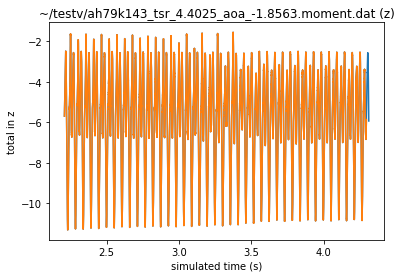

In [16]:
omega =4.4025*40/3
values = analyze('~/testv/ah79k143_tsr_4.4025_aoa_-1.8563.moment.dat', omega, 'z', plot=True)
calc_cp(values, omega)

## Testing with Haris's data

In [18]:
## Areas is 1.575

Time in a half rotation (seconds): 0.096989262994881
Number of half rotations: 31.607622383539507
Filtering to 60134 points
Average torque (Nm): 4.59344278546748
Average power (W): -148.7868415937062
Cp: -0.18893567186502377
Time in a half rotation (seconds): 0.06887763867995264
Number of half rotations: 30.31812457600696
Filtering to 53994 points
Average torque (Nm): -47.70798030242478
Average power (W): -2176.0188547132598
Cp: -2.7631985456676316
Time in a half rotation (seconds): 0.06317139595168361
Number of half rotations: 46.943615149301834
Filtering to 82789 points
Average torque (Nm): 45.98066697109518
Average power (W): -2286.676167074658
Cp: -2.9037157677138516
Time in a half rotation (seconds): 0.048957903086732354
Number of half rotations: 43.124624767112664
Filtering to 77397 points
Average torque (Nm): -211.2088495225913
Average power (W): -13553.116620575664
Cp: -17.21030681977862
Time in a half rotation (seconds): 0.08350772188387368
Number of half rotations: 21.2767748

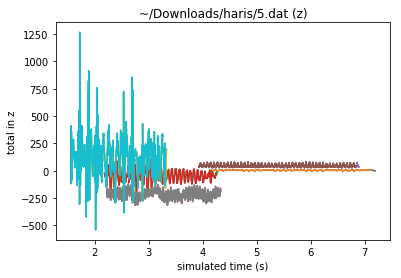

In [19]:
omegas = [-32.39113853, 45.61121307, -49.73125267,64.16926493,-37.62038507]
for i in range(5):
    omega =omegas[i]
    values = analyze('~/Downloads/haris/%s.dat' % str(i+1), omega, 'z', plot=True)
    calc_cp(values, omega, THEORETICAL_MAX=(0.5 * 1 *  1.575 * (10**3)))

Time in a half rotation (seconds): 0.19022865645089485
Number of half rotations: 28.095136136229907
Filtering to 71019 points
Average torque (Nm): -11.76467892011527
Average power (W): -194.29159389987885
Cp: -0.24671948431730648
Time in a half rotation (seconds): 0.19017061389318782
Number of half rotations: 23.972552365848486
Filtering to 58319 points
Average torque (Nm): -51.405452015809594
Average power (W): -849.2110694769915
Cp: -1.0783632628279256
Time in a half rotation (seconds): 0.19032853418956275
Number of half rotations: 24.765992235853034
Filtering to 60906 points
Average torque (Nm): -25.531027310889268
Average power (W): -421.41914337765417
Cp: -0.5351354201621005
Time in a half rotation (seconds): 0.1902459959202514
Number of half rotations: 21.77943341176484
Filtering to 53269 points
Average torque (Nm): -2.286624456750598
Average power (W): -37.759757098161046
Cp: -0.04794889790242673
Time in a half rotation (seconds): 0.19008798868346685
Number of half rotations: 26

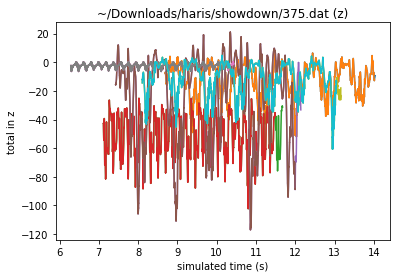

In [20]:
omegas = [16.51482333,16.51986387,16.50615693,16.51331813,16.52704453]
for i in range(5):
    omega =omegas[i]
    values = analyze('~/Downloads/haris/showdown/%s.dat' % str(i+371), omega, 'z', plot=True)
    calc_cp(values, omega, THEORETICAL_MAX=(0.5 * 1 *  1.575 * (10**3)))